In [1]:
import torch
import torchvision
from torchvision.models.resnet import resnet50, ResNet50_Weights
import glob
import os
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from torchaudio.transforms import MelSpectrogram, Vad, TimeStretch, Spectrogram, GriffinLim, FrequencyMasking, TimeMasking
from sklearn.metrics import confusion_matrix
import random
import pandas as pd
import convert_dataset
import seaborn

# local library
from models import SpeechCommandClassifier
from preprocess import stereo2mono, zero_pad_if_necessary, RandomClip, ComposeTransform

In [2]:
TRAIN_PATH = "./data_train"
TEST_PATH = "./data_test"
sample_rate = 48000

In [3]:
class SpeechCommandDataset(Dataset):
    def __init__(self, data_path: str, min_lenth: float = 1.5, sr: int = 48000, augment = True) -> None:
        super().__init__()

        self.sr = sr
        self.all_file = glob.glob(f"{data_path}/**/*")
        self.augment = augment
        random.shuffle(self.all_file)
        self.commands = [c.split("/")[-1] for c in glob.glob(f"{data_path}/**")]
        self.preprocessor = ComposeTransform([
            RandomClip(sample_rate=sr, clip_length=48000 + 24000),
            MelSpectrogram(sample_rate=sr, n_mels=32, n_fft=1024, hop_length=512),
        ])
        self.augmentor  = ComposeTransform([
            TimeMasking(time_mask_param=10)
        ])
        self.min_sample_length = int(min_lenth * sr)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        f = self.all_file[index]
        command = self.commands.index(f.split("/")[-2])
        mel = self._preprocess(f)
        return mel, torch.tensor(command)

    def _stereo2mono(self, wav: torch.Tensor):
        return stereo2mono(wav)

    def _zero_pad_if_necessary(self, wav: torch.Tensor):
        return zero_pad_if_necessary(wav, self.min_sample_length)

    def _preprocess(self, path):
        wav, sr = torchaudio.load(path)
        wav = self._stereo2mono(wav)
        wav = self._zero_pad_if_necessary(wav)
        mel = self.preprocessor(wav)
        if self.augment:
            mel = self.augmentor(mel)
        mel = (mel + torch.tensor(1e-6)).log2()
        return mel.unsqueeze(0)

    def plot_mel_spectrogram(self, mel: torch.Tensor, label: torch.Tensor | int | str):
        plt.figure()
        if (type(label) == torch.Tensor):
            lab = self.commands[label]
        elif (type(label == int)):
            lab = self.commands[label]
        else:
            lab = label
        plt.imshow(mel.cpu(), label=lab)
        plt.show()
    def __len__(self) -> int:
        return len(self.all_file)

batch_size = 64

train_dataset = SpeechCommandDataset(TRAIN_PATH)
test_dataset = SpeechCommandDataset(TEST_PATH, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataset), len(test_dataset))
print(train_dataset.commands)

503 95
['ปิดเพลง', 'อื่น ๆ', 'เอคโค่', 'เล่นเพลงต่อ', 'เล่นเพลงถัดไป', 'หยุดเพลง', 'เปิดเพลง', 'เล่นเพลงก่อนหน้า']


torch.Size([1, 32, 141]) tensor(5)


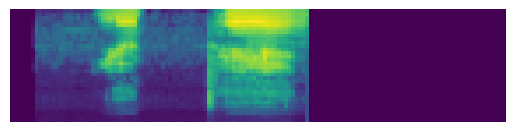

In [48]:
for i in range(len(train_dataset)):
    mel, label = train_dataset[i]
    print(mel.shape, label)
    plt.imshow(mel[0])
    plt.axis("off")
    plt.show()
    break
    

In [5]:
def cal_acc(y_pred: torch.Tensor, y: torch.Tensor) -> float:
    y_pred = torch.argmax(y_pred, dim=1)
    score = (y_pred == y).sum()
    return score / len(y)

In [6]:
model = SpeechCommandClassifier(input_shapes=(1, 32, 141), num_classes=len(train_dataset.commands))
EPOCHS = 50
LR = 2e-3
optimizer = optim.RMSprop(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [7]:
print(model)

SpeechCommandClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(50, 200, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=47600, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=200, out_features=8, bias=True)
  )
)


In [8]:
# Training Phase
best_test_acc = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()
model = model.to(device)
for epoch in range(EPOCHS):
    for i, batch in enumerate(train_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss: torch.Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            model.eval()
            train_acc = cal_acc(y_pred, y)

            for test_batch in test_loader:
                x_test, y_test = test_batch
                x_test, y_test = x_test.to(device), y_test.to(device)

                y_test_pred = model(x_test)
                loss_test = loss_fn(y_test_pred, y_test)

                test_acc = cal_acc(y_test_pred, y_test)
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    torch.save(model.state_dict(), "best_model.pth")
                break

            print(f"Epoch: {epoch + 1} step: {i + 1} train_loss: {loss.item()} train_acc: {train_acc} test_loss: {loss_test.item()} test_acc: {test_acc}")
            model.train()


Epoch: 1 step: 1 train_loss: 2.067521333694458 train_acc: 0.140625 test_loss: 3311.857666015625 test_acc: 0.109375
Epoch: 1 step: 2 train_loss: 1156.743408203125 train_acc: 0.125 test_loss: 2.2880210876464844 test_acc: 0.140625
Epoch: 1 step: 3 train_loss: 2.69978666305542 train_acc: 0.109375 test_loss: 2.0777645111083984 test_acc: 0.125
Epoch: 1 step: 4 train_loss: 2.1864771842956543 train_acc: 0.078125 test_loss: 2.075282335281372 test_acc: 0.171875
Epoch: 1 step: 5 train_loss: 2.1618499755859375 train_acc: 0.125 test_loss: 2.0809054374694824 test_acc: 0.109375
Epoch: 1 step: 6 train_loss: 2.13476300239563 train_acc: 0.109375 test_loss: 2.079508066177368 test_acc: 0.1875
Epoch: 1 step: 7 train_loss: 2.1397581100463867 train_acc: 0.109375 test_loss: 2.0805697441101074 test_acc: 0.109375
Epoch: 1 step: 8 train_loss: 2.0517897605895996 train_acc: 0.1818181723356247 test_loss: 2.076671838760376 test_acc: 0.109375
Epoch: 2 step: 1 train_loss: 2.098311185836792 train_acc: 0.125 test_loss: 

In [11]:
print(f"Best test accuracy: {best_test_acc}")

Best test accuracy: 0.703125


torch.Size([95, 8]) torch.Size([95])


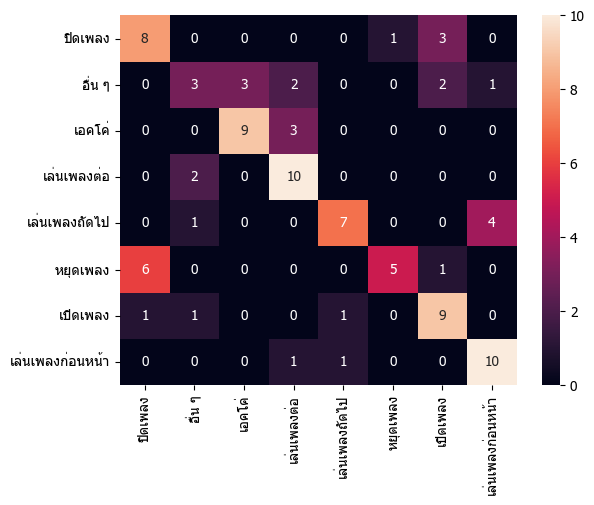

In [10]:
# Set Thai font
plt.rcParams['font.family'] = 'Tahoma'
model.eval()
model = model.cpu()
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

batch = next(iter(test_loader))

x, y = batch

y_pred = model(x)
print(y_pred.shape, y.shape)
y_pred = torch.argmax(y_pred, dim=1)

cf_mat = confusion_matrix(y, y_pred)
c = test_dataset.commands
seaborn.heatmap(cf_mat, fmt='d', xticklabels=c, yticklabels=c, annot=True);